<a href="https://colab.research.google.com/github/GUILLENJV/Series-de-Tiempo-/blob/master/Predicci%C3%B3n_del_precio_del_Bitcoin_usando_MLT(Multilayer_Perceptron).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción del precio del Bitcoin usando MLT(Multilayer Perceptron)

### Series de Tiempo con Multilayer Perceptron

In [ ]:
# Warnings
import warnings
warnings.filterwarnings('ignore')
# biblioteca matemática para la función matemática
import math
# vista de datos etiquetados en dataframe
import pandas as pd
# el lector de datos od panda se utiliza para obtener los datos de la web
import pandas_datareader as web
# numpy se utiliza para crear matrices multidimensionales
import numpy as np
# tensorflow se utiliza para crear el modelo DL y envolver las otras bibliotecas
import tensorflow as tf
# sklearn proporciona funciones de ultilidad para estandarizar o escalar datos
from sklearn.preprocessing import MinMaxScaler
# sklearn proporciona funciones de ultilidad para calcular el error absoluto
from sklearn.metrics import mean_absolute_error
# keras es una biblioteca de redes neuronales
from keras.layers import Dense,Activation,Flatten, Dropout, LSTM
from keras.models import Sequential
# se incluye para crear un área de gràficos
import matplotlib.pyplot as mtlplt
import matplotlib.pylab as plt
# distribución de la escala de características
from matplotlib import rcParams
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
from pandas import read_csv
import seaborn as sns
import json
import requests

# Conjunto de datos
El conjunto de datos históricos sobre el precio del bitcoin, se obtuvo de la pagina web https://min-api.cryptocompare.com . Que contiene sobre los precios del bitcoin de los ultimos 1000 dias correspondientes al periodo 2018-06-30 al 2021-03-16 con formato de valores separados por comas (.csv), también tiene un tipo diferente de precio en particular. Mediante la obtención de un conjunto de datos, se obtienen las características y el comportamiento finalizados de los precio.

## Descripción de cada atributo

Describe el atributo del conjunto de datos que se proporciona a continuación. Los valores de los atributos están en punto flotante.

* **time** :   Periodo de tiempo

* **open** :  este es el precio del precio de apertura del  del bitcoin, que significa el precio inicial de un día de negociación en particular, pero que no es el mismo precio del precio final del día de la cotización.

* **high** :  este es el precio más alto del precio del bitcoin  la acción en un día de negociación en particular.

* **low** :  este es el precio del bitcoin más bajo durante el día de negociación.

* **close** :  este es el precio de cierre del bitcoin durante el día de negociación en particular.

Adj Close:  este es el precio final o de cierre de las acciones que se modificó para contener las acciones y la distribución de las corporaciones que se produjeron durante la hora de negociación del día.

* **volumefrom** :  este es el precio  del meracado en un día en particular.

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
dataset=hist.drop(['volumeto','conversionType','conversionSymbol'],axis=1)

In [ ]:
dataset.tail(3)

,high,low,open,volumefrom,close
time,,,,,
2021-03-20,59911.70,57837.79,58060.21,28696.46,58101.34
2021-03-21,58621.34,55635.61,58101.34,34236.52,57374.95
2021-03-22,58431.44,56339.79,57374.95,19984.71,57076.57


In [ ]:
dataset.describe()

,high,low,open,volumefrom,close
count,201.000000,201.000000,201.000000,201.000000,201.000000
mean,27736.334378,25792.352786,26761.772139,53693.321144,26988.644378
std,16368.666202,14959.090856,15706.314315,32468.546333,15812.269111
min,10349.090000,9855.680000,10128.540000,9901.250000,10128.540000
25%,13197.690000,12732.620000,12937.200000,32665.610000,12990.250000
50%,19553.230000,18888.120000,19274.690000,45852.830000,19378.940000
75%,39695.430000,36199.190000,37677.340000,65660.600000,38202.080000
max,61749.150000,58980.950000,61179.790000,240328.000000,61179.790000


# Preprocesamiento de datos
La primera etapa necesitamos importar todas las bibliotecas necesarias. El conjunto de datos recopilados se leyó utilizando la biblioteca panda en Python y muestra los registros para comprender el conjunto de datos para el preprocesamiento. En este punto, podemos identificar los comportamientos y las características del conjunto de datos.

Visualización de datos dados en un formato de gráfico de trama para el comportamiento de crecimiento y disminución de los precios del Bitcoin. Además de mostrar únicamente los cambios en el precio de cierre del Bitcoin con respecto a esa fecha de negociación.

Podemos observar que los precios siguen en aumento  Los precios siguen aumentando desde abril de 2019 hasta la presente fecha con ciertas fluctuaciones.

In [ ]:
df = read_csv('crypto.csv', sep =';')

<function matplotlib.pyplot.show>

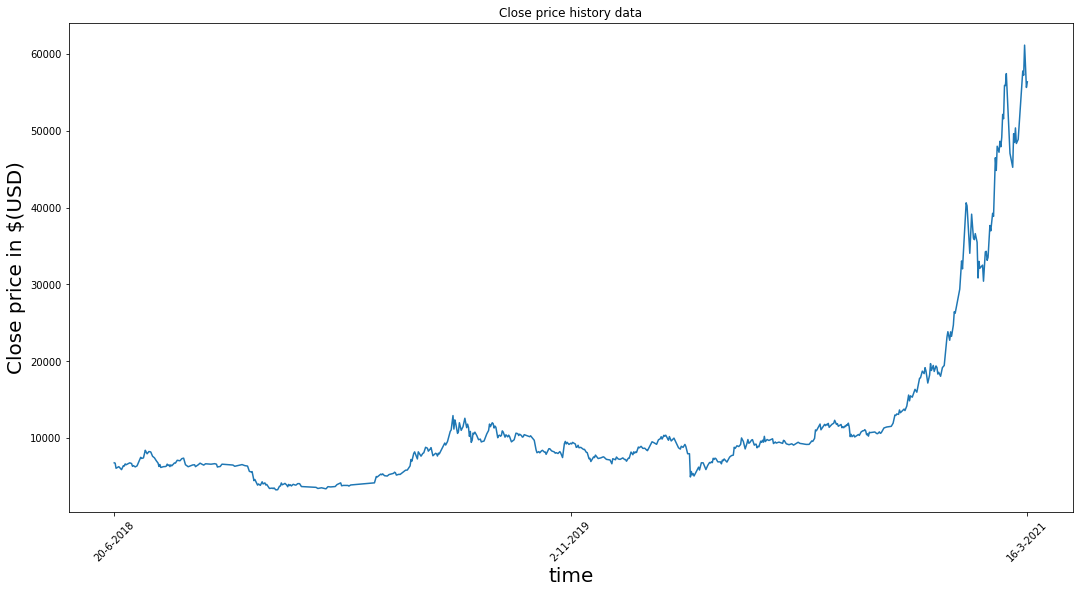

In [ ]:
## Visulaizing close price on graph from historical data
mtlplt.figure(figsize=(18,9))
mtlplt.title('Close price history data')
mtlplt.plot(df['close'])
#plt.plot(range(data_frame.shape[0]),(data_frame['Low']+data_frame['High'])/2.0)
mtlplt.xticks(range(0,df.shape[0],500),df['time'].loc[::500],rotation=45)
mtlplt.xlabel('time', fontsize=20)
mtlplt.ylabel('Close price in $(USD)',fontsize=20)
mtlplt.show

El primer paso es preparar el conjunto de datos. Esto implica enmarcar el conjunto de datos como un problema de aprendizaje supervisado y normalizar las variables de entrada.

Enmarcaremos el problema de aprendizaje supervisado como una predicción del precio del Bitcoin diario en el paso de tiempo anterior. Para hacer la transformaciòn usaremos la funciòn `series_to_supervised ()`, crea automáticamente nuevos marcos de problemas de series de tiempo dada la longitud deseada de las secuencias de entrada y salida. La función toma cuatro argumentos:

* **data** : Secuencia de observaciones como una lista o matriz 2D NumPy. Requerido.
* **n_in** : Número de observaciones de retardo como entrada ( X ). Los valores pueden estar entre [1..len (datos)] Opcional. Por defecto es 1.
* **n_out** : Número de observaciones como salida ( y ). Los valores pueden estar entre [0..len (datos) -1]. Opcional. Por defecto es 1.
* **dropnan** : booleano para eliminar filas con valores NaN. Opcional. El valor predeterminado es Verdadero.

La función devuelve un solo valor:

* **return** : Pandas DataFrame de series enmarcadas para aprendizaje supervisado.

El nuevo conjunto de datos se construye como un DataFrame, con cada columna adecuadamente nombrada tanto por número de variable como por paso de tiempo. Esto le permite diseñar una variedad de diferentes tipos de problemas de pronóstico de secuencia de pasos de tiempo a partir de una determinada serie de tiempo univariante o multivariante.

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

El escalado de características y la normalización de datos son la mejor manera de reducir la tasa de error y mejorar la precisión del modelo. La normalización es una técnica que a menudo se aplica como parte de la preparación de datos para el aprendizaje automático. El objetivo de la normalización es cambiar los valores de las columnas numéricas en el conjunto de datos a una escala común, sin distorsionar las diferencias en los rangos de valores.
Antes de usar la función, utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1 (pues sabemos que a nuestra red neuronal, le favorece para realizar los cálculos).

In [ ]:
PASOS=7

# load dataset
values = dataset['close'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

dataset['scaled'] = scaled
scaledMerge=dataset.drop('close',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03,6286.36,6067.49,6260.40,62925.30,-0.901432,6192.11,6021.69,6092.26,62639.82,-0.899596,6172.23,5844.26,6141.57,63585.51,-0.908925,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895
2018-07-04,6192.11,6021.69,6092.26,62639.82,-0.899596,6172.23,5844.26,6141.57,63585.51,-0.908925,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117
2018-07-05,6172.23,5844.26,6141.57,63585.51,-0.908925,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117,6691.32,6448.23,6589.77,63771.67,-0.886024
2018-07-06,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117,6691.32,6448.23,6589.77,63771.67,-0.886024,6633.44,6458.14,6534.81,47259.68,-0.883704
2018-07-07,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117,6691.32,6448.23,6589.77,63771.67,-0.886024,6633.44,6458.14,6534.81,47259.68,-0.883704,6814.42,6518.23,6602.03,41785.10,-0.878318


# Dividimos en set de Entrenamiento y Validación

In [ ]:
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)','var4(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(994, 36)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03,6286.36,6067.49,6260.40,62925.30,-0.901432,6192.11,6021.69,6092.26,62639.82,-0.899596,6172.23,5844.26,6141.57,63585.51,-0.908925,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,-0.886895
2018-07-04,6192.11,6021.69,6092.26,62639.82,-0.899596,6172.23,5844.26,6141.57,63585.51,-0.908925,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,-0.884117
2018-07-05,6172.23,5844.26,6141.57,63585.51,-0.908925,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117,-0.886024
2018-07-06,6286.67,5813.02,5870.81,92884.98,-0.897448,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117,6691.32,6448.23,6589.77,63771.67,-0.886024,-0.883704
2018-07-07,6503.33,6194.51,6203.81,65571.19,-0.891181,6429.50,6262.72,6385.43,40809.54,-0.892781,6673.71,5537.86,6342.69,73069.19,-0.883233,6670.30,6473.48,6616.60,54662.02,-0.886895,6777.97,6411.13,6508.43,62355.75,-0.884117,6691.32,6448.23,6589.77,63771.67,-0.886024,6633.44,6458.14,6534.81,47259.68,-0.883704,-0.878318


Usaremos como entradas las columnas encabezadas como var1(t-7) a  var5(t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var5(t) -la última columna-.

A continuación, dividí los datos en dos conjuntos: conjunto de entrenamiento y conjunto de prueba con 80% y 20% de datos respectivamente.

In [ ]:
# split into train and test sets
values = newReframed.values
n_train_days = 1001 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(964, 1, 35) (964,) (30, 1, 35) (30,)


Por lo tanto, haremos una subdivisión de los primeros 964 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación.

Hemos transformado la entrada en un arreglo con forma (964,1,35) esto al castellano significa algo así como “964 entradas con vectores de 1×35”.

# Definir y ajustar modelo

La arquitectura de la red neuronal será:

* Entrada 150 inputs, como dijimos antes
* 1 capa oculta con 35 neuronas (este valor lo escogí yo, pero se puede variar)
* La salida será 1 sola neurona
* Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.
* Utilizaremos como optimizador Rmsprop y métrica de pérdida (loss) Mean Absolute Error
* Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [ ]:
from keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization

In [ ]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS*5),activation='tanh', kernel_initializer = 'he_uniform', activity_regularizer=l1(0.001)))
    model.add(Flatten())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(1, activation='tanh', kernel_initializer = 'he_uniform'))
    model.compile(loss='mean_absolute_error',optimizer='adam',metrics=["mse"])
    model.summary()
    return model

In [ ]:
EPOCHS=100

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=100,validation_data=(x_val,y_val),batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 7)              252       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 288
Trainable params: 274
Non-trainable params: 14
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 44ms/step - loss: 0.6702 - mse: 0.6970 - val_loss: 1.3650 - val_mse: 1.9493
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6617 - mse: 0.6816 - val_loss: 1.3543 - val_mse: 

30


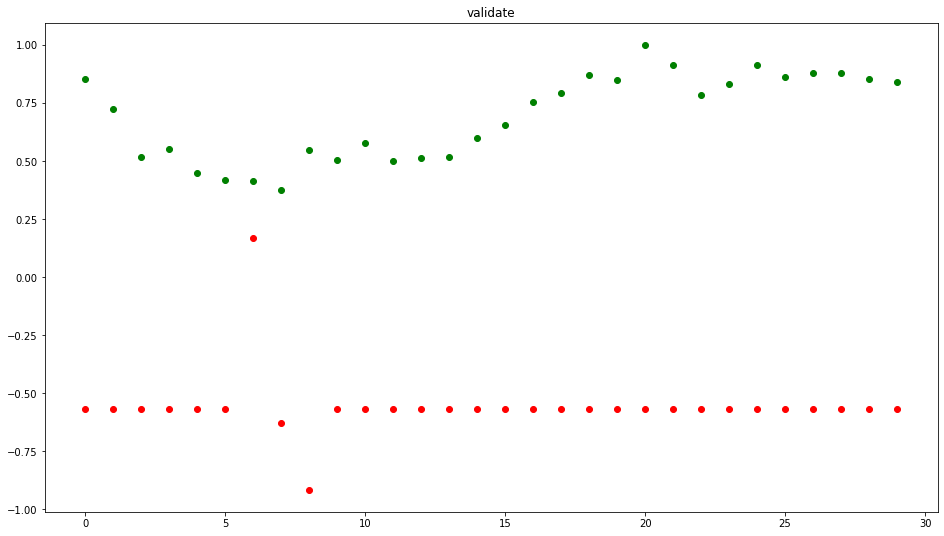

In [ ]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

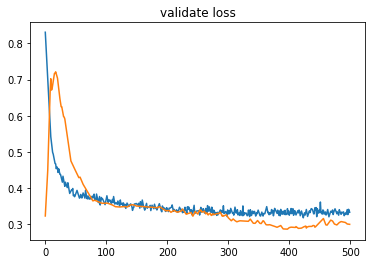

In [ ]:
#plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Veamos y comparemos también cómo disminuye el LOSS tanto en el conjunto de train como el de Validate, esto es bueno ya que indica que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

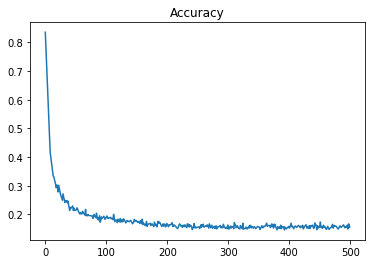

In [ ]:
#plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,57469.951373,52888.267822,4581.683551
1,54121.169944,56235.900559,-2114.730615
2,48898.700566,59713.361314,-10814.660747
3,49738.170485,39866.611800,9871.558686
4,47082.870160,51034.025472,-3951.155312
5,46324.499391,33259.463524,13065.035867
6,46191.391136,55516.959581,-9325.568444
7,45261.030043,18279.869108,26981.160935
8,49635.071229,28091.761632,21543.309596
9,48501.210667,27129.023410,21372.187257


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,53287.087871,52552.259689,734.828182
std,4741.332503,11629.081653,9234.463126
min,45261.030043,18279.869108,-10814.660747
25%,48894.275441,50866.926216,-4003.175067
50%,54524.934287,56222.147449,-2076.964525
75%,57446.200082,60820.670363,2167.824511
max,61179.790159,61120.090146,26981.160935


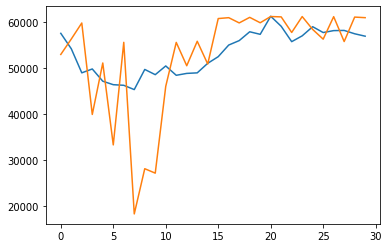

In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

In [ ]:
ultimosDias = dataset['2021-03-09':'2021-03-22']
ultimosDias

,high,low,open,volumefrom,close,scaled
time,,,,,,
2021-03-09,54933.93,51888.98,52405.02,53740.22,54928.70,0.755105
2021-03-10,57396.59,53054.34,54928.70,70138.56,55893.31,0.792895
2021-03-11,58142.77,54314.65,55893.31,59202.98,57809.41,0.867961
2021-03-12,58069.58,55089.68,57809.41,54282.31,57256.22,0.846289
2021-03-13,61749.15,56103.32,57256.22,57862.75,61179.79,1.000000
2021-03-14,61674.66,58980.95,61179.79,34886.85,58998.89,0.914560
2021-03-15,60589.17,54857.68,58998.89,75161.15,55665.01,0.783951
2021-03-16,56936.04,53269.13,55665.01,62540.93,56925.01,0.833313
2021-03-17,58975.28,54156.11,56925.01,62035.71,58909.00,0.911039


In [ ]:
scaledMerge=ultimosDias.drop('close',axis=1)
print(scaledMerge.values)

[[5.49339300e+04 5.18889800e+04 5.24050200e+04 5.37402200e+04
  7.55105257e-01]
 [5.73965900e+04 5.30543400e+04 5.49287000e+04 7.01385600e+04
  7.92895079e-01]
 [5.81427700e+04 5.43146500e+04 5.58933100e+04 5.92029800e+04
  8.67960930e-01]
 [5.80695800e+04 5.50896800e+04 5.78094100e+04 5.42823100e+04
  8.46288919e-01]
 [6.17491500e+04 5.61033200e+04 5.72562200e+04 5.78627500e+04
  1.00000000e+00]
 [6.16746600e+04 5.89809500e+04 6.11797900e+04 3.48868500e+04
  9.14560318e-01]
 [6.05891700e+04 5.48576800e+04 5.89988900e+04 7.51611500e+04
  7.83951283e-01]
 [5.69360400e+04 5.32691300e+04 5.56650100e+04 6.25409300e+04
  8.33313465e-01]
 [5.89752800e+04 5.41561100e+04 5.69250100e+04 6.20357100e+04
  9.11038876e-01]
 [6.00777900e+04 5.70222000e+04 5.89090000e+04 5.42897100e+04
  8.61454248e-01]
 [5.94533200e+04 5.62833700e+04 5.76433200e+04 4.11824100e+04
  8.77786398e-01]
 [5.99117000e+04 5.78377900e+04 5.80602100e+04 2.86964600e+04
  8.79397631e-01]
 [5.86213400e+04 5.56356100e+04 5.810134

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida “Y” pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)'],axis=1)
newReframed.head(7)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-16,54933.93,51888.98,52405.02,53740.22,0.755105,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951
2021-03-17,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313
2021-03-18,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313,58975.28,54156.11,56925.01,62035.71,0.911039
2021-03-19,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313,58975.28,54156.11,56925.01,62035.71,0.911039,60077.79,57022.20,58909.00,54289.71,0.861454
2021-03-20,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313,58975.28,54156.11,56925.01,62035.71,0.911039,60077.79,57022.20,58909.00,54289.71,0.861454,59453.32,56283.37,57643.32,41182.41,0.877786
2021-03-21,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313,58975.28,54156.11,56925.01,62035.71,0.911039,60077.79,57022.20,58909.00,54289.71,0.861454,59453.32,56283.37,57643.32,41182.41,0.877786,59911.70,57837.79,58060.21,28696.46,0.879398
2021-03-22,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313,58975.28,54156.11,56925.01,62035.71,0.911039,60077.79,57022.20,58909.00,54289.71,0.861454,59453.32,56283.37,57643.32,41182.41,0.877786,59911.70,57837.79,58060.21,28696.46,0.879398,58621.34,55635.61,58101.34,34236.52,0.850940


De este conjunto “ultimosDias” tomamos sólo la última fila, pues es la que correspondería a la última semana de noviembre y la dejamos en el formato correcto para la red neuronal con reshape:

In [ ]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(1, 1, 35)
[[[6.05891700e+04 5.48576800e+04 5.89988900e+04 7.51611500e+04
   7.83951283e-01 5.69360400e+04 5.32691300e+04 5.56650100e+04
   6.25409300e+04 8.33313465e-01 5.89752800e+04 5.41561100e+04
   5.69250100e+04 6.20357100e+04 9.11038876e-01 6.00777900e+04
   5.70222000e+04 5.89090000e+04 5.42897100e+04 8.61454248e-01
   5.94533200e+04 5.62833700e+04 5.76433200e+04 4.11824100e+04
   8.77786398e-01 5.99117000e+04 5.78377900e+04 5.80602100e+04
   2.86964600e+04 8.79397631e-01 5.86213400e+04 5.56356100e+04
   5.81013400e+04 3.42365200e+04 8.50940228e-01]]]


Ahora crearemos una función para ir “rellenando” el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los siguientes 7  días.

In [ ]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [ ]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[6.05891700e+04 5.48576800e+04 5.89988900e+04 7.51611500e+04
   7.83951283e-01 5.69360400e+04 5.32691300e+04 5.56650100e+04
   6.25409300e+04 8.33313465e-01 5.89752800e+04 5.41561100e+04
   5.69250100e+04 6.20357100e+04 9.11038876e-01 6.00777900e+04
   5.70222000e+04 5.89090000e+04 5.42897100e+04 8.61454248e-01
   5.94533200e+04 5.62833700e+04 5.76433200e+04 4.11824100e+04
   8.77786398e-01 5.99117000e+04 5.78377900e+04 5.80602100e+04
   2.86964600e+04 8.79397631e-01 5.86213400e+04 5.56356100e+04
   5.81013400e+04 3.42365200e+04 8.50940228e-01]]]
pred 1 [[[7.51611500e+04 7.83951283e-01 5.69360400e+04 5.32691300e+04
   5.56650100e+04 6.25409300e+04 8.33313465e-01 5.89752800e+04
   5.41561100e+04 5.69250100e+04 6.20357100e+04 9.11038876e-01
   6.00777900e+04 5.70222000e+04 5.89090000e+04 5.42897100e+04
   8.61454248e-01 5.94533200e+04 5.62833700e+04 5.76433200e+04
   4.11824100e+04 8.77786398e-01 5.99117000e+04 5.78377900e+04
   5.80602100e+04 2.86964600e+04 8.79397631e-01 5.862

Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” precio. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes

In [ ]:
adimen = [x for x in results]
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.987874], dtype=float32), array([-1.], dtype=float32), array([-1.], dtype=float32), array([1.], dtype=float32), array([0.95684433], dtype=float32), array([-1.], dtype=float32), array([-1.], dtype=float32)]


array([[60870.26569437],
       [10128.5388771 ],
       [10128.5388771 ],
       [61179.79015934],
       [60078.21467839],
       [10128.5388771 ],
       [10128.5388771 ]])

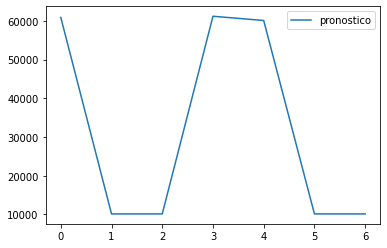

In [ ]:
prediccion1= pd.DataFrame(inverted)
prediccion1.columns = ['pronostico']
prediccion1.plot()
prediccion1.to_csv('pronostico_multivariate.csv')

In [ ]:
prediccion1

,pronostico
0,60870.265694
1,10128.538877
2,10128.538877
3,61179.790159
4,60078.214678
5,10128.538877
6,10128.538877


# Modelo 2

In [ ]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS*5),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='rmsprop',metrics=["mse"])
    model.summary()
    return model

In [ ]:
EPOCHS=500

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=500,validation_data=(x_val,y_val),batch_size=16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              252       
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
61/61 [==============================] - 1s 8ms/step - loss: 1.6436 - mse: 2.8470 - val_loss: 0.5645 - val_mse: 0.5116
Epoch 2/500
61/61 [==============================] - 0s 2ms/step - loss: 1.5856 - mse: 2.6715 - val_loss: 0.7398 - val_mse: 0.7265
Epoch 3/500
61/61 [==============================] - 0s 2ms/step - loss: 1.5131 - mse: 2.4785 - val_loss: 0.9476 - val_mse: 1.

30


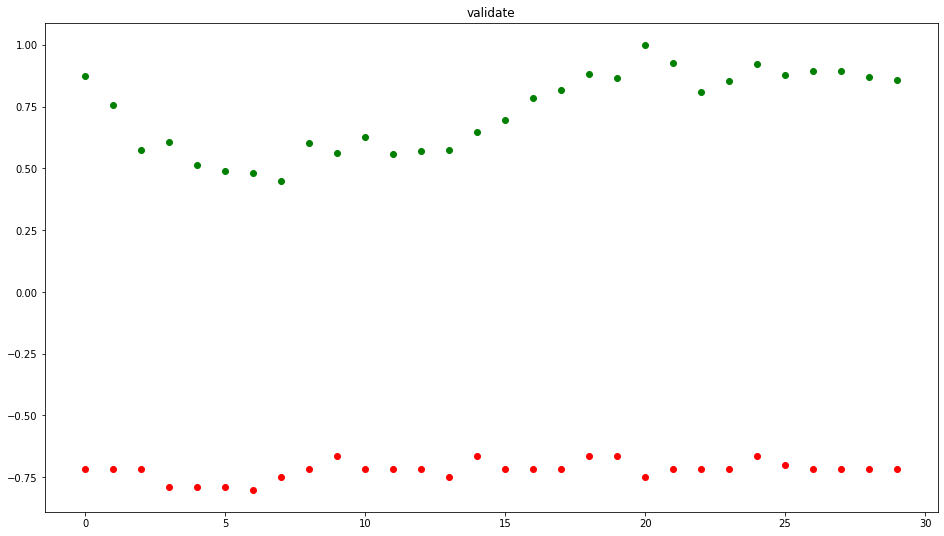

In [ ]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

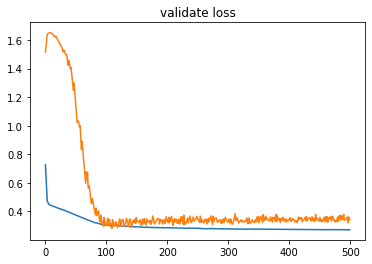

In [ ]:
#plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

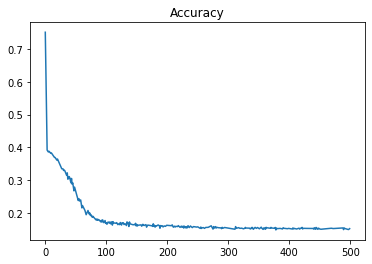

In [ ]:
#plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,57469.951373,59124.984732,-1655.033359
1,54121.169944,34556.336739,19564.833206
2,48898.700566,55636.207463,-6737.506897
3,49738.170485,41052.998378,8685.172108
4,47082.870160,25974.385223,21108.484937
5,46324.499391,23761.458211,22563.041180
6,46191.391136,45981.619508,209.771629
7,45261.030043,49330.324104,-4069.294061
8,49635.071229,18149.733759,31485.337470
9,48501.210667,34406.452547,14094.758120


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,53272.913270,47280.818604,5992.094666
std,4730.938614,13936.699868,11476.096454
min,45261.030043,14555.027344,-9560.344275
25%,48894.275441,40093.240858,-1653.406173
50%,54524.934287,53859.306292,385.851219
75%,57446.200082,58185.639120,11415.972091
max,61179.790159,60512.639197,33808.711561


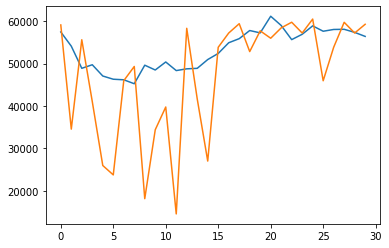

In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [ ]:
ultimosDias = dataset['2021-03-05':'2021-03-18']
ultimosDias

,high,low,open,volumefrom,close,scaled
time,,,,,,
2021-03-05,49467.19,46311.43,48363.74,60955.82,48775.37,0.514041
2021-03-06,49185.32,47099.07,48775.37,25116.42,48892.80,0.518641
2021-03-07,51455.54,48892.80,48892.80,32958.26,50964.18,0.599790
2021-03-08,52408.08,49341.09,50964.18,48084.28,52405.02,0.656237
2021-03-09,54933.93,51888.98,52405.02,53740.22,54928.70,0.755105
2021-03-10,57396.59,53054.34,54928.70,70138.56,55893.31,0.792895
2021-03-11,58142.77,54314.65,55893.31,59202.98,57809.41,0.867961
2021-03-12,58069.58,55089.68,57809.41,54282.31,57256.22,0.846289
2021-03-13,61749.15,56103.32,57256.22,57862.75,61179.79,1.000000


In [ ]:
scaledMerge=ultimosDias.drop('close',axis=1)
print(scaledMerge.values)

[[4.94671900e+04 4.63114300e+04 4.83637400e+04 6.09558200e+04
  5.14040589e-01]
 [4.91853200e+04 4.70990700e+04 4.87753700e+04 2.51164200e+04
  5.18640995e-01]
 [5.14555400e+04 4.88928000e+04 4.88928000e+04 3.29582600e+04
  5.99789977e-01]
 [5.24080800e+04 4.93410900e+04 5.09641800e+04 4.80842800e+04
  6.56236887e-01]
 [5.49339300e+04 5.18889800e+04 5.24050200e+04 5.37402200e+04
  7.55105257e-01]
 [5.73965900e+04 5.30543400e+04 5.49287000e+04 7.01385600e+04
  7.92895079e-01]
 [5.81427700e+04 5.43146500e+04 5.58933100e+04 5.92029800e+04
  8.67960930e-01]
 [5.80695800e+04 5.50896800e+04 5.78094100e+04 5.42823100e+04
  8.46288919e-01]
 [6.17491500e+04 5.61033200e+04 5.72562200e+04 5.78627500e+04
  1.00000000e+00]
 [6.16746600e+04 5.89809500e+04 6.11797900e+04 3.48868500e+04
  9.14560318e-01]
 [6.05891700e+04 5.48576800e+04 5.89988900e+04 7.51611500e+04
  7.83951283e-01]
 [5.69360400e+04 5.32691300e+04 5.56650100e+04 6.25409300e+04
  8.33313465e-01]
 [5.89752800e+04 5.41561100e+04 5.692501

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)'],axis=1)
newReframed.head(7)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-12,49467.19,46311.43,48363.74,60955.82,0.514041,49185.32,47099.07,48775.37,25116.42,0.518641,51455.54,48892.80,48892.80,32958.26,0.599790,52408.08,49341.09,50964.18,48084.28,0.656237,54933.93,51888.98,52405.02,53740.22,0.755105,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961
2021-03-13,49185.32,47099.07,48775.37,25116.42,0.518641,51455.54,48892.80,48892.80,32958.26,0.599790,52408.08,49341.09,50964.18,48084.28,0.656237,54933.93,51888.98,52405.02,53740.22,0.755105,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289
2021-03-14,51455.54,48892.80,48892.80,32958.26,0.599790,52408.08,49341.09,50964.18,48084.28,0.656237,54933.93,51888.98,52405.02,53740.22,0.755105,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000
2021-03-15,52408.08,49341.09,50964.18,48084.28,0.656237,54933.93,51888.98,52405.02,53740.22,0.755105,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560
2021-03-16,54933.93,51888.98,52405.02,53740.22,0.755105,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951
2021-03-17,57396.59,53054.34,54928.70,70138.56,0.792895,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313
2021-03-18,58142.77,54314.65,55893.31,59202.98,0.867961,58069.58,55089.68,57809.41,54282.31,0.846289,61749.15,56103.32,57256.22,57862.75,1.000000,61674.66,58980.95,61179.79,34886.85,0.914560,60589.17,54857.68,58998.89,75161.15,0.783951,56936.04,53269.13,55665.01,62540.93,0.833313,58975.28,54156.11,56925.01,62035.71,0.911039


In [ ]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(1, 1, 35)
[[[5.81427700e+04 5.43146500e+04 5.58933100e+04 5.92029800e+04
   8.67960930e-01 5.80695800e+04 5.50896800e+04 5.78094100e+04
   5.42823100e+04 8.46288919e-01 6.17491500e+04 5.61033200e+04
   5.72562200e+04 5.78627500e+04 1.00000000e+00 6.16746600e+04
   5.89809500e+04 6.11797900e+04 3.48868500e+04 9.14560318e-01
   6.05891700e+04 5.48576800e+04 5.89988900e+04 7.51611500e+04
   7.83951283e-01 5.69360400e+04 5.32691300e+04 5.56650100e+04
   6.25409300e+04 8.33313465e-01 5.89752800e+04 5.41561100e+04
   5.69250100e+04 6.20357100e+04 9.11038876e-01]]]


In [ ]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [ ]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[5.81427700e+04 5.43146500e+04 5.58933100e+04 5.92029800e+04
   8.67960930e-01 5.80695800e+04 5.50896800e+04 5.78094100e+04
   5.42823100e+04 8.46288919e-01 6.17491500e+04 5.61033200e+04
   5.72562200e+04 5.78627500e+04 1.00000000e+00 6.16746600e+04
   5.89809500e+04 6.11797900e+04 3.48868500e+04 9.14560318e-01
   6.05891700e+04 5.48576800e+04 5.89988900e+04 7.51611500e+04
   7.83951283e-01 5.69360400e+04 5.32691300e+04 5.56650100e+04
   6.25409300e+04 8.33313465e-01 5.89752800e+04 5.41561100e+04
   5.69250100e+04 6.20357100e+04 9.11038876e-01]]]
pred 1 [[[5.92029800e+04 8.67960930e-01 5.80695800e+04 5.50896800e+04
   5.78094100e+04 5.42823100e+04 8.46288919e-01 6.17491500e+04
   5.61033200e+04 5.72562200e+04 5.78627500e+04 1.00000000e+00
   6.16746600e+04 5.89809500e+04 6.11797900e+04 3.48868500e+04
   9.14560318e-01 6.05891700e+04 5.48576800e+04 5.89988900e+04
   7.51611500e+04 7.83951283e-01 5.69360400e+04 5.32691300e+04
   5.56650100e+04 6.25409300e+04 8.33313465e-01 5.897

In [ ]:
adimen = [x for x in results]
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.40381402], dtype=float32), array([0.9495055], dtype=float32), array([0.9430115], dtype=float32), array([-0.07169013], dtype=float32), array([0.5998809], dtype=float32), array([-0.11684278], dtype=float32), array([0.9265635], dtype=float32)]


array([[45961.76996452],
       [59890.88665823],
       [59725.12361153],
       [33824.22916778],
       [50966.49914122],
       [32671.67954547],
       [59305.27758661]])

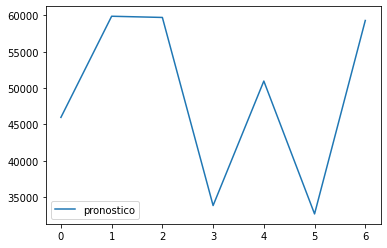

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_multivariate.csv')

In [ ]:
prediccion1SemanaDiciembre

,pronostico
0,45961.769965
1,59890.886658
2,59725.123612
3,33824.229168
4,50966.499141
5,32671.679545
6,59305.277587
